# Politweet, summarizing political debates through Twitter


The scope of this project is to build a tool that can summarize a political debate, taking into account what aspects of the debate people liked and understanding the bipolarity of the twittersphere.

The following is an example of the dataset provided.

In [77]:
%matplotlib inline
import re
import pandas as pd
pd.set_option('display.max_colwidth', 1200)
import numpy as np
from IPython.display import display
import nltk
from __future__ import unicode_literals
from spacy.en import English
nlp = English()

In [81]:
# Retrieving the tweets from a file
def get_tweets(filename):
    df = pd.read_csv(filename, sep='\t', encoding='utf-8', index_col="tweet.id")
    return df

def get_debate(filename):
    df = pd.read_csv(filename, encoding='utf-8')
    return df

all = get_tweets("./debate08_sentiment_tweets.tsv")
debate = get_debate("./debatetranscript.csv")
display(all[:1])
display(debate[:3])

,pub.date.GMT,content,author.name,author.nickname,rating.1,rating.2,rating.3,rating.4,rating.5,rating.6,rating.7,rating.8
tweet.id,,,,,,,,,,,,
936469851,9/27/08 1:01,Watching by myself #tweetdebate Not drinking :( waiting to start cringing at McCains blunders,drgilpin,Dawn Gilpin,1,1,4,NaN,NaN,NaN,NaN,NaN


,date,who,text
0,00:01:10,MR. LEHRER,"Good evening from the Ford Center for the Performing Arts at the University of Mississippi in Oxford. I'm Jim Lehrer of""The News Hour"" on PBS, and I welcome you to the first of the 2008presidential debates between the Republican nominee, Senator John McCain of Arizona, and the Democratic nominee, Senator Barack Obama of Illinois.The Commission on Presidential Debates is the sponsor of this event, and the three other presidential and vice presidential debates coming in October.Tonight's will primarily be about foreign policy and national security, which by definition includes the global financial crisis.It will be divided roughly into nine-minute segments. Direct exchanges between the candidates and moderator follow-ups are permitted after each candidate has two minutes to answer the lead question in an order determined by a coin toss.The specific subjects and questions were chosen by me. They have not been shared or cleared with anyone.The audience here in the hall has promised to remain silent -- no cheers, no applause, no noise of any kind -- except right now, as we welcome Senators Obama and McCain. (Cheers, applause.)Let me begin with something General Eisenhower said in hi..."
1,00:03:24,SEN. OBAMA,"Well, thank you very much, Jim, and thanks to the commission and the University of Mississippi, Ole Miss, for hosting us tonight. I can't think of a more important time for us to talk about the future of the country.You know, we are at a defining moment in our history. Our nation is involved in two wars, and we are going through the worst financial crisis since the Great Depression. And although we've heard a lot about Wall Street, those of you on Main Street, I think, have been struggling for a while, and you recognize that this could have an impact on all sectors of the economy. And you're wondering: How's it going to affect me? How's it going to affect my job? How's it going to affect my house? How's it going to affect my retirement savings or my ability to send my children to college?So we have to move swiftly and we have to move wisely.And I've put forward a series of proposals that make sure that we protect taxpayers as we engage in this important rescue effort.Number one, we've got to make sure that we've got oversight over this whole process. $700 billion potentially is a lot of money.Number two, we've got to make sure that taxpayers, when they are putting their money a..."
2,00:05:32,MR. LEHRER,"Senator McCain, two minutes."


In [31]:
# Function to nicely print out the tweets
def list_content(df):
    for i, row in enumerate(zip(df["author.name"].values, df["content"].values)):
        print i, row

list_content(all[:3])

0 (u'drgilpin', u'Watching by myself  #tweetdebate Not drinking :( waiting to start cringing at McCains blunders')
1 (u'starweaver', u"@ahg3 @MichDot Yeah, slime was actually my second choice, can't say what the first one was. Okay, we're rolling...")
2 (u'kyeung808', u'Preparing to have a heart attack #tweetdebate')


## Pre-processing

Before starting building our tools, we aimed at cleaning the data and pre-process it. For example, we perform sentence and word tokenization and we normalize all the mentions to McCain and Obama. There are cases in which McCain is mispelled

In [45]:
# We apply this function to pre-process the data
# This cleans error and tokenize the tweets into word tokens
def pre_processing(df):
    df["content"] = df["content"].apply(lambda x: re.sub(r'MCCAINs?', 'McCain', x, flags=re.IGNORECASE))
    df["content"] = df["content"].apply(lambda x: re.sub(r'Obama|Barack', 'Obama', x, flags=re.IGNORECASE))
    df["tokens"] = df["content"].apply(lambda x: nltk.tokenize.word_tokenize(x))
    return df_setminus(df, all_rating(df, Rating.OTHER))

df = pre_processing(all)
print "Example of word tokens"
df[["tokens"]][:1]

Example of word tokens


,tokens
tweet.id,
936466790,"[Jim, Lehrer, just, directed, the, debate, audience, ..., 30, seconds, ..., #, tweetdebate]"


## Sentiment

Our first step is build a sentiment analysis classifier. We will use this to understand whether users are expressing positive or negative sentiment towards a topic and a candidate. In addition, we aim at improving the scores given by Amazon Mechanical Turks, which do not grade the tweets with this depth of details. However, we use the AMT ratings only when all the ratings are equal. We use this our label for our training set.

### Approaches
Our approaches for sentiment analysis will be the following:

1. Rule-based system
2. Using a lexicon
3. Machine learning techniques

Our assumption is that given the specificity of the topic, open-domain machine learning techniques for sentiment analysis, such as Socher 2014 (Recursive Neural Networks) would not satisfy our needs in this particular case, since we may want to train the network with data that are more precise to our problem, however our dataset is too small to do such test. Hence, we attempt at using existing lexicons such as SentiWordnet.

After our exporatory data analysis stage, we found that there are very simple rules that we can understand from the different tweets. For example, "-3 Obama" is a notation that is used in the tweets to specify that the user disagree with something Obama has said, hence we can can collect rules of this kind and build a rule-based system for sentiment analysis. In addition, we plan to use the outcome of the different rules into a classifier and learn their weights.

The following code consists in helping function to retrieve all the tweets that contains *some* ratings of the same kind and *all* ratings of the same kind.

In [46]:
rating = {1:"negative", 2:"positive", 3:"mixed", 4:"other" }

# This static class will help us to filter for Rating.NEGATIVE, etc.
class Rating:
    NEGATIVE = 1
    POSITIVE = 2
    MIXED = 3
    OTHER = 4

# At least one of thar rating
def some_rating(df, rating):
    return df[
        (df["rating.1"]==rating) |
        (df["rating.2"]==rating) |
        (df["rating.3"]==rating) |
        (df["rating.4"]==rating) |
        (df["rating.5"]==rating) |
        (df["rating.6"]==rating) |
        (df["rating.7"]==rating) |
        (df["rating.8"]==rating)
    ]

# Everyone with the same rating
def all_rating(df, rating):
    return df[
        ((df["rating.1"]==rating) | (df["rating.1"] != df["rating.1"])) &
        ((df["rating.2"]==rating) | (df["rating.2"] != df["rating.2"])) &
        ((df["rating.3"]==rating) | (df["rating.3"] != df["rating.3"])) &
        ((df["rating.4"]==rating) | (df["rating.4"] != df["rating.4"])) &
        ((df["rating.5"]==rating) | (df["rating.5"] != df["rating.5"])) &
        ((df["rating.6"]==rating) | (df["rating.6"] != df["rating.6"])) &
        ((df["rating.7"]==rating) | (df["rating.7"] != df["rating.7"])) &
        ((df["rating.8"]==rating) | (df["rating.8"] != df["rating.8"]))
    ]

In [47]:
some_negative = some_rating(df, Rating.NEGATIVE)
all_negative = all_rating(df, Rating.NEGATIVE)

some_positive = some_rating(df, Rating.POSITIVE)
all_positive = all_rating(df, Rating.POSITIVE)

print "At least one negative"
display(some_negative[:1][["content", "rating.1", "rating.2", "rating.3"]])
print "All negative"
display(all_negative[:1][["content", "rating.1", "rating.2", "rating.3"]])
print "All positive"
display(all_positive[:1][["content", "rating.1", "rating.2", "rating.3"]])

At least one negative


,content,rating.1,rating.2,rating.3
tweet.id,,,,
936469851,Watching by myself #tweetdebate Not drinking :( waiting to start cringing at McCain blunders,1,1,4


All negative


,content,rating.1,rating.2,rating.3
tweet.id,,,,
936470432,"@ahg3 @MichDot Yeah, slime was actually my second choice, can't say what the first one was. Okay, we're rolling...",1,1,1


All positive


,content,rating.1,rating.2,rating.3
tweet.id,,,,
936469906,Current TV is pretty cool. Streaming Twitter feedback #tweetdebate,2,2,2


### Exploring the polarity rule-based

At this stage, we decided to explore whether we can find a simple matching rule to define the polarity ...Showing tweets that have -1, -2, -3.. in the text, in order to write a rule-based system

In [58]:
# regular expressions to match - and +
plus_regex = re.compile(".*(\+[0-9]+).*")
minus_regex = re.compile(".*([^0-9]\-[0-9]+).*")
mccain_regex = re.compile(".*(mcpain|mclame).*", flags=re.IGNORECASE)

# Extract all the tweets with -
def minus_df(df):
    return df[df["content"].str.contains("[^0-9]\-[0-9]+")]

# Extract all the tweets with +
def plus_df(df):
    return df[df["content"].str.contains("\+[0-9]+")]

minus_rule = minus_df(all_negative)
plus_rule = plus_df(all_positive)

print "Negative tweets with -"
list_content(minus_rule[:3])
print "\nPositive tweets with -"
list_content(plus_rule[:3])
print "\nThere are in total " + str( len (minus_rule + plus_rule) ) + " matched documents"

Negative tweets with -
0 (u'themurmish', u'McCain just gave a cheap plug to Ed Kennedy -1 #tweetdebate #current')
1 (u'dabloguiman', u'McCain -2 for not knowing Kennedy is home and watching the debate  #tweetdebate')
2 (u'ferret67', u'McCain is talking about bipartisan negotiation? Uh...no... -1 pt. #tweetdebate #current')

Positive tweets with -
0 (u'naum', u'Obama +1 for swift and wise  #tweetdebate')
1 (u'nohype', u'+1 for Obama "Moving fast, moving swiftly" #tweetdebate')
2 (u'fritzpw', u'" Obama +1 for articulating his plans - initial & recognition #tweetdebate"')

There are in total 225 matched documents


#### Exploring a naive bayes classifier

We decided to use our rules as a features into a Naive Bayes Classifier.

Hence we write two regular expressions to match + and - tweets, previously filtered by same-rating by ATM

In [59]:
# Extract features of a document
def document_features(document):
    document_words = set(document["tokens"])
    document_words_l = (d.lower() for d in set(document["tokens"]))
    features = {}
    # Positive/Negative polarity if contains a +/-
    features['polarity(+)'] = plus_regex.match(document["content"]) != None
    features['polarity(-)'] = minus_regex.match(document["content"]) != None
    # Point out that contains the word Obama/McCain
    features['topic(obama)'] = "obama" in document_words_l
    features['topic(mccain)'] = "mccain" in document_words_l
    
    return features

In order to train the classifier, we decided to split the two datasets 80% training, 20% test.
The following result shows a really great outcome of our very simple classifier. 100% of the tweets are marked correctly

In [60]:
# splits the data in train, dev using the factor
def split_dataset(dataset, factor):
    limit = int(len(dataset)*factor)
    return dataset[:limit], dataset[limit:]

#  label each document with `pos` or `neg` if contain the rule
pos = [(document_features(d), "pos") for i, d in plus_rule.iterrows()]
neg = [(document_features(d), "neg") for i, d in minus_rule.iterrows()]

# split the datasets
pos_train, pos_test = split_dataset(pos, 0.8)
neg_train, neg_test = split_dataset(neg, 0.8)

# join the train and the test
train_set = pos_train + neg_train
test_set = pos_train + neg_train

# run the classifier
classifier = nltk.NaiveBayesClassifier.train(train_set)
print(nltk.classify.accuracy(classifier, test_set))
classifier.show_most_informative_features(5)

1.0
Most Informative Features
            topic(obama) = False             neg : pos    =      3.2 : 1.0
            topic(obama) = True              pos : neg    =      2.8 : 1.0
           topic(mccain) = True              neg : pos    =      1.2 : 1.0
           topic(mccain) = False             pos : neg    =      1.0 : 1.0


In [61]:
# Use this an example to test your sentence
for_example = "Obama was crap +1"
for_example_tokens = nltk.tokenize.word_tokenize(for_example)
for_example_doc = dict(tokens=for_example_tokens, content=for_example)
classifier.classify(document_features(for_example_doc))

u'pos'

How does this classifier performs on tweets that are not marked with the same score by ATM?

In [62]:
# This does the set minus operations over the tweet ids
def df_setminus(d1, d2):
    index = d1.index.difference(d2.index)
    return d1.reindex(index)

# Getting the tweet that have not marked all in the same way
# but contain at least one positive for disagreeing positive
# and one negative, for disagreeing negative
# We further filter them with the minus and the plus rule
minus_rule_disagreeing = plus_df(df_setminus(some_positive, all_positive))
plus_rule_disagreeing = minus_df(df_setminus(some_negative, all_negative))

disagreeing = pd.concat([
        plus_rule_disagreeing,
        df_setminus(minus_rule_disagreeing, plus_rule_disagreeing)])

disagreeing_classified = classifier.classify_many([document_features(d) for i,d in disagreeing.iterrows()])
disagreeing["sent"] = pd.Series(disagreeing_classified, index=disagreeing.index)
print "We matched %i disagreeing judgments on -/+ tweets" % len(disagreeing)
disagreeing[["content", "sent"]][:3]

We matched 178 disagreeing judgments on -/+ tweets


,content,sent
tweet.id,,
936475544,Obama -2 it an occupation not war #tweetdebate,neg
936478533,McCain -3 for Kenndey comment #tweetdebate,neg
936480927,@kgs @CSPAN-2 :),neg


We found out that there are some tweets which contain more than + and - in a tweet, however since they are just 28 we will not care.

In [63]:
matches = df[df["content"].str.contains('((\+|\-)[0-9]+.*(\+|\-)[0-9]+)+')]
len(matches)

28

### Beyond polarity
Is there any other rule for sentiment analysis that we can look at?

In [64]:
no_polarity = df_setminus(df_setminus(df, minus_df(df)), plus_df(df))
no_polarity[:1]

,pub.date.GMT,content,author.name,author.nickname,rating.1,rating.2,rating.3,rating.4,rating.5,rating.6,rating.7,rating.8,tokens
tweet.id,,,,,,,,,,,,,
936466790,9/27/08 1:00,Jim Lehrer just directed the debate audience ... 30 seconds ... #tweetdebate,B_E_X,Becky L,4,2,4,NaN,NaN,NaN,NaN,NaN,"[Jim, Lehrer, just, directed, the, debate, audience, ..., 30, seconds, ..., #, tweetdebate]"


Do smiles appear?

In [21]:
def happy_df(df):
    return df[df["content"].str.contains("[:;8=xX]-?[\)\]D]")]

def sad_df(df):
    return df[df["content"].str.contains("[:;8=]'?-?[\(\[\|]")]


happy_smiles = happy_df(df)
sad_smiles = sad_df(df)
len(happy_smiles) + len(sad_smiles)

46

In [23]:
from nltk.corpus import wordnet as wn
wn.synsets(str("bad"), pos=wn.ADJ)

[Synset('bad.a.01'),
 Synset('bad.s.02'),
 Synset('bad.s.03'),
 Synset('bad.s.04'),
 Synset('regretful.a.01'),
 Synset('bad.s.06'),
 Synset('bad.s.07'),
 Synset('bad.s.08'),
 Synset('bad.s.09'),
 Synset('bad.s.10'),
 Synset('bad.s.11'),
 Synset('bad.s.12'),
 Synset('bad.s.13'),
 Synset('bad.s.14')]

# Topic modeling


## Hashtags

Here we attempt exploratory topic modelling, starting from understanding how hashtags are used.
However, how we can see from the following examples, hashtags haven't been used to point out the topic discussed. Only three tweets contain hashtags different from #tweetdebate, #current, #debate, #debate08. Hence, the results are trivial for further analysis

WRONG


In [66]:
# we get all the tweets that do not contain
# the hashtags #tweetdebate, #current, #debate
# but that still contain a hashtag
# TODO

with_hashtags = df[
    (df["content"].str.contains(".*(#tweetdebate)?.*#[a-zA-Z]+.*(#tweetdebate)?"))
]
list_content(with_hashtags)

0 (u'B_E_X', u'Jim Lehrer just directed the debate audience ... 30 seconds ... #tweetdebate')
1 (u'Jonathan Fields', u'Here we go. #tweetdebate')
2 (u'joebird', u'#tweetdebate letting mom/dad follow debate on CNN while tweet scoring. I will sleep on the sofa with them & wait for the screams GO Obama')
3 (u'ferret67', u'what is an appropriately bi-partisan food to bring to a debate party? #tweetdebate')
4 (u'kyeung808', u"@current I've got the live stream going #current....awesome!")
5 (u'naum', u"watching the debate on current TV in SF. let's go! #tweetdebate")
6 (u'drgilpin', u'Watching by myself  #tweetdebate Not drinking :( waiting to start cringing at McCain blunders')
7 (u'shashib', u'Current TV is pretty cool. Streaming Twitter feedback #tweetdebate')
8 (u'barbaranixon', u'#tweetdebate the first debate is about to start')
9 (u'kyeung808', u'#tweetdebate - good luck both candidates')
10 (u'bluejack', u'Just ordered pizza and got the cat settled, ready to watch the debates #tweetde

## Obama/McCain 


We have seen some sentences that contain both Obama and McCain, how many are them? and how many are twe onces not mentioning them?

In [74]:
obama = df[df["content"].str.contains('obama', flags=re.IGNORECASE)]
mccain = df[df["content"].str.contains('mccain', flags=re.IGNORECASE)]
both = obama.index & mccain.index
none = df[~(df["content"].str.contains('obama|mccain', flags=re.IGNORECASE))]

print "All tweets %i" % len(df)
print "There are %i tweets that mention Obama" % len(obama)
print "There are %i tweets that mention McCain" % len(mccain)
print "There are %i tweets that mention both Obama and McCain" % len(both)
print "There are %i tweets that no Obama and McCain" % len(none)

ambiguous = df_setminus(none, all_rating(none, Rating.POSITIVE))
ambiguous = df_setminus(ambiguous, all_rating(none, Rating.NEGATIVE))

# They were 144
some_rating(ambiguous, Rating.OTHER)[500:600]

All tweets 3087
There are 1068 tweets that mention Obama
There are 1172 tweets that mention McCain
There are 468 tweets that mention both Obama and McCain
There are 1315 tweets that no Obama and McCain


,pub.date.GMT,content,author.name,author.nickname,rating.1,rating.2,rating.3,rating.4,rating.5,rating.6,rating.7,rating.8,tokens
tweet.id,,,,,,,,,,,,,
936685994,9/27/08 2:47,"Ok, Harold Ford coming on. Time to stop watching and make a drink. TGIF! #debate08",FrancesFlynnTho,FrancesFlynnTho,1,4,2,NaN,NaN,NaN,NaN,NaN,"[Ok, ,, Harold, Ford, coming, on, ., Time, to, stop, watching, and, make, a, drink, ., TGIF, !, #, debate08]"
936686075,9/27/08 2:47,"Gearing up to watch an Independent Viewpoint on Bill Maher at 11 pm ET. In the end, 3 #tweetdebate viewpoints better than 2. Perspective...",rebot,NaN,1,4,4,NaN,NaN,NaN,NaN,NaN,"[Gearing, up, to, watch, an, Independent, Viewpoint, on, Bill, Maher, at, 11, pm, ET, ., In, the, end, ,, 3, #, tweetdebate, viewpoints, better, than, 2, ., Perspective, ...]"
936686167,9/27/08 2:47,"On NBC, interesting that Biden is on for the dems, but Guiliani for the reps. Where's Sarah? Hiding her? #debate08",aagha,aagha,4,4,2,NaN,NaN,NaN,NaN,NaN,"[On, NBC, ,, interesting, that, Biden, is, on, for, the, dems, ,, but, Guiliani, for, the, reps., Where, 's, Sarah, ?, Hiding, her, ?, #, debate08]"
936686302,9/27/08 2:47,"#debate08 Biden vs. Guilani in the NBC after shock - where is Palin?... Palin declined, and the GOP offered Guilani.",DOWNSOKC,NaN,3,1,4,NaN,NaN,NaN,NaN,NaN,"[#, debate08, Biden, vs., Guilani, in, the, NBC, after, shock, -, where, is, Palin, ?, ..., Palin, declined, ,, and, the, GOP, offered, Guilani, .]"
936686428,9/27/08 2:47,Guiliani is a twit #current,lindagoin,NaN,4,1,1,NaN,NaN,NaN,NaN,NaN,"[Guiliani, is, a, twit, #, current]"
936686628,9/27/08 2:47,To watch what people said while the candidates were talking made it able to keep the attention better #current #debate08,martinbowling,martinbowling,2,4,2,NaN,NaN,NaN,NaN,NaN,"[To, watch, what, people, said, while, the, candidates, were, talking, made, it, able, to, keep, the, attention, better, #, current, #, debate08]"
936686660,9/27/08 2:47,#debate08 FTW T. Boone Pickens again? The hell?,gminks,Gina Minks,1,4,1,NaN,NaN,NaN,NaN,NaN,"[#, debate08, FTW, T., Boone, Pickens, again, ?, The, hell, ?]"
936686691,9/27/08 2:47,"#debate08 oh god, here comes Giuliani",danramteke,Daniel R,4,1,1,NaN,NaN,NaN,NaN,NaN,"[#, debate08, oh, god, ,, here, comes, Giuliani]"
936686752,9/27/08 2:47,lol @martinbowling I was thinking morse code #tweetdebate,damnneargenius,NaN,4,1,1,4,NaN,NaN,NaN,NaN,"[lol, @, martinbowling, I, was, thinking, morse, code, #, tweetdebate]"


# Clustering

The following graph shows the distribution of tweets per user.

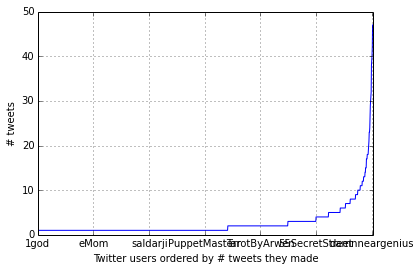

In [251]:
ax = df.groupby("author.name").size().order().plot()
ax.set_xlabel("Twitter users ordered by # tweets they made")
ax.set_ylabel("# tweets")